<a href="https://colab.research.google.com/github/sakurararann/sakurararann.github.io/blob/main/KEGG_N_Glycan_%E8%A9%A6%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N-Glycan Biosynthesis Pathway - Homo Sapiens (Human)

# 準備するべきファイル
- **hsa00510.xml** from KEGG(https://www.kegg.jp/pathway/hsa00510)
- **rna_tissue_consensus.tsv** from HPA(https://www.proteinatlas.org/humanproteome/tissue/data#consensus_tissues_rna)

##このXMLデータの概要
糖鎖→糖鎖（使われている酵素）の情報が入っている．

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

tree = ET.parse("hsa00510.xml")
root = tree.getroot()

entries = []
for entry in root.findall("./entry"):
    entries.append({
        "id": entry.get("id"),
        "type": entry.get("type"),
        "name": entry.get("name"),
        "graphics_name": entry.find("graphics").get("name") if entry.find("graphics") is not None else ""
    })

df = pd.DataFrame(entries)
print(df.head(5))

   id      type           name                           graphics_name
0  39      gene     hsa:199857             ALG14, CMS15, IDDEBF, MEPCA
1  40      gene      hsa:54344           DPM3, CDG1O, MDDGB15, MDDGC15
2  41      gene       hsa:8818                             DPM2, CDG1U
3  42       map  path:hsa00513  Various types of N-glycan biosynthesis
4  43  compound      gl:G10596                                  G10596


##可視化
Cytoscapeで可視化できるようにデータを保存

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import networkx as nx

# === ファイル名を指定 ===
KGML_FILE = "hsa00510.xml"
OUTPUT_GRAPHML = "glycan_synthesis_only.graphml"

# === None を防ぐ便利関数 ===
def safe(value):
    return value if value is not None else ""

# === XMLをパース ===
tree = ET.parse(KGML_FILE)
root = tree.getroot()

# === Entry（compoundだけ） ===
entries = []
for entry in root.findall("./entry"):
    if entry.get("type") == "compound":
        entries.append({
            "id": safe(entry.get("id")),
            "type": safe(entry.get("type")),
            "name": safe(entry.get("name")),
            "graphics_name": safe(
                entry.find("graphics").get("name") if entry.find("graphics") is not None else ""
            )
        })
df_entry = pd.DataFrame(entries)
print("=== Compound Entries ===")
print(df_entry.head())

# === Reaction（基質→生成物） ===
reactions = []
for reaction in root.findall("./reaction"):
    reaction_id = safe(reaction.get("id"))
    reaction_name = safe(reaction.get("name"))  # EC番号が入る
    reaction_type = safe(reaction.get("type"))
    for substrate in reaction.findall("substrate"):
        for product in reaction.findall("product"):
            reactions.append({
                "reaction_id": reaction_id,
                "reaction_name": reaction_name,
                "reaction_type": reaction_type,
                "substrate": safe(substrate.get("name")),
                "product": safe(product.get("name"))
            })
df_reaction = pd.DataFrame(reactions)
print("\n=== Reactions ===")
print(df_reaction.head())

# === NetworkX DiGraph ===
G = nx.DiGraph()

# === ノード追加（compoundのみ） ===
for _, row in df_entry.iterrows():
    G.add_node(
        row["id"],
        type=safe(row["type"]),
        name=safe(row["name"]),
        label=safe(row["graphics_name"])
    )

# === Reactionエッジ（基質→生成物、酵素情報付き） ===
for _, row in df_reaction.iterrows():
    substrate_matches = df_entry[df_entry["name"] == row["substrate"]]
    product_matches = df_entry[df_entry["name"] == row["product"]]
    if not substrate_matches.empty and not product_matches.empty:
        substrate_id = substrate_matches["id"].values[0]
        product_id = product_matches["id"].values[0]

        # EC番号を enzyme 属性として付与
        G.add_edge(
            substrate_id,
            product_id,
            edge_type="reaction",
            enzyme=row["reaction_name"],      # EC番号 or KO番号
            reaction_name=row["reaction_name"],  # ✅ 差分テーブルと一致させるために必須
            reaction_id=row["reaction_id"],      # ✅ 必要なら ID も残す
            reaction_type=row["reaction_type"]
        )
    else:
        print(f"Skipped: {row['substrate']} -> {row['product']}")

print(f"\n=== Graph Summary ===")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")

# === GraphML保存 ===
nx.write_graphml(G, OUTPUT_GRAPHML)
print(f"\n✅ GraphML saved to: {OUTPUT_GRAPHML}")

=== Compound Entries ===
   id      type       name graphics_name
0  43  compound  gl:G10596        G10596
1  48  compound  gl:G00022        G00022
2  49  compound  gl:G00021        G00021
3  50  compound  gl:G00020        G00020
4  51  compound  gl:G00019        G00019

=== Reactions ===
  reaction_id reaction_name reaction_type   substrate     product
0          39     rn:R05970  irreversible   gl:G00001   gl:G00002
1          40     rn:R01009  irreversible  cpd:C00096  cpd:C03862
2          40     rn:R01009  irreversible  cpd:C00110  cpd:C03862
3          41     rn:R01009  irreversible  cpd:C00096  cpd:C03862
4          41     rn:R01009  irreversible  cpd:C00110  cpd:C03862
Skipped: gl:G10618 -> gl:G10598
Skipped: gl:G10617 -> gl:G10595
Skipped: gl:G10614 -> gl:G00003

=== Graph Summary ===
Nodes: 40
Edges: 41

✅ GraphML saved to: glycan_synthesis_only.graphml


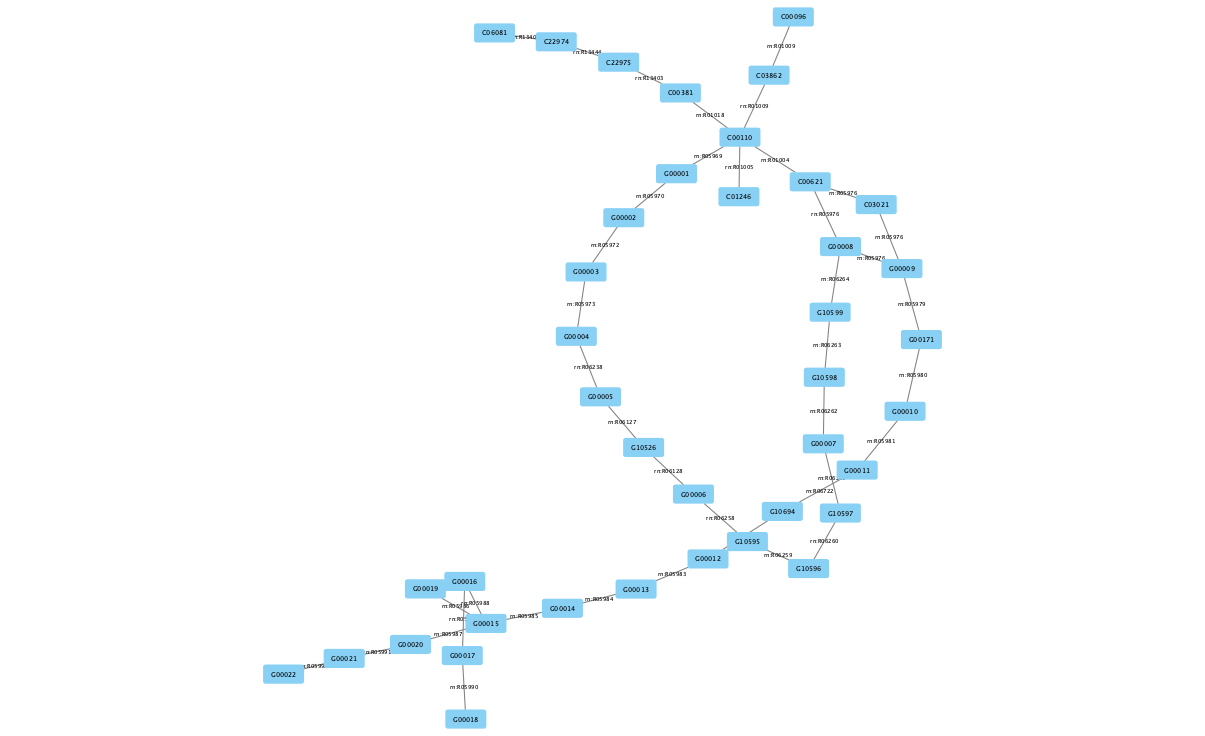

In [ ]:
# === Reaction（基質→生成物） === はすでに抽出済みとして

# パスウェイで登場する酵素（EC番号）のユニーク一覧
used_ec_numbers = df_reaction["reaction_name"].unique()

print("=== このパスウェイで使われている酵素（EC番号） ===")
for ec in used_ec_numbers:
    print(ec)

=== このパスウェイで使われている酵素（EC番号） ===
rn:R05970
rn:R01009
rn:R06264
rn:R06263
rn:R06262
rn:R06260
rn:R06259
rn:R06258
rn:R05991
rn:R01004
rn:R05988
rn:R05992
rn:R05989
rn:R05990
rn:R05986
rn:R05985
rn:R05984
rn:R05983
rn:R06722
rn:R05987
rn:R05980
rn:R05979
rn:R06128
rn:R05976
rn:R01005
rn:R06261
rn:R06127
rn:R06238
rn:R05973
rn:R05972
rn:R05969
rn:R01018
rn:R05981
rn:R13444
rn:R12479
rn:R13402
rn:R13403


## 酵素のIDから名前をゲット

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import requests

# === ファイル指定 ===
KGML_FILE = "hsa00510.xml"

def safe(value):
    return value if value is not None else ""

# === XMLロード & reaction抽出 ===
tree = ET.parse(KGML_FILE)
root = tree.getroot()

# === Reaction IDs を抽出 ===
reactions = []
for reaction in root.findall("./reaction"):
    reaction_id = safe(reaction.get("id"))
    reaction_name = safe(reaction.get("name"))  # rn:XXXXX
    reaction_type = safe(reaction.get("type"))
    for substrate in reaction.findall("substrate"):
        for product in reaction.findall("product"):
            reactions.append({
                "reaction_id": reaction_id,
                "reaction_name": reaction_name,  # Reaction ID
                "reaction_type": reaction_type,
                "substrate": safe(substrate.get("name")),
                "product": safe(product.get("name"))
            })

df_reaction = pd.DataFrame(reactions)

# === 登場する Reaction ID をユニークに抽出 ===
reaction_ids = sorted(df_reaction["reaction_name"].unique())
print("=== 登場する Reaction IDs ===")
for rn in reaction_ids:
    print(rn)

# === KEGG REST API 関数 ===

# Reaction ID → EC番号
def get_ec_numbers_from_reaction(rn_id):
    url = f"https://rest.kegg.jp/get/{rn_id}"
    response = requests.get(url)
    ec_numbers = []
    if response.ok:
        for line in response.text.split("\n"):
            if line.startswith("ENZYME"):
                parts = line.split()
                ec_numbers = parts[1:]  # ENZYME の後に複数のEC番号が並ぶ場合あり
                break
    return ec_numbers

# EC番号 → KEGG Gene IDs
def get_gene_ids_from_ec(ec_number):
    url = f"https://rest.kegg.jp/link/hsa/enzyme:{ec_number}"
    response = requests.get(url)
    gene_ids = []
    if response.ok:
        lines = response.text.strip().split("\n")
        for line in lines:
            parts = line.split("\t")
            if len(parts) == 2:
                gene_ids.append(parts[1])
    return gene_ids

# KEGG Gene ID → Gene Symbol（SYMBOL行優先、NAME fallback）
def get_gene_symbol(gene_id):
    url = f"https://rest.kegg.jp/get/{gene_id}"
    response = requests.get(url)
    symbol = ""
    if response.ok:
        for line in response.text.split("\n"):
            if line.startswith("SYMBOL") and not symbol:
                parts = line.split()
                if len(parts) >= 2:
                    symbol = parts[1].replace(",", "")
            elif line.startswith("NAME") and not symbol:
                parts = line.split()
                if len(parts) >= 2:
                    symbol = parts[1].replace(",", "")
    return symbol

# === Reaction ID → EC番号 → Gene Symbol を全展開 ===

mapping_rows = []

for rn in reaction_ids:
    ec_numbers = get_ec_numbers_from_reaction(rn)
    if ec_numbers:
        for ec in ec_numbers:
            gene_ids = get_gene_ids_from_ec(ec)
            if gene_ids:
                for gid in gene_ids:
                    symbol = get_gene_symbol(gid)
                    mapping_rows.append({
                        "Reaction_ID": rn,
                        "EC": ec,
                        "Gene_Symbol": symbol
                    })
            else:
                mapping_rows.append({
                    "Reaction_ID": rn,
                    "EC": ec,
                    "Gene_Symbol": ""
                })
    else:
        mapping_rows.append({
            "Reaction_ID": rn,
            "EC": "",
            "Gene_Symbol": ""
        })

# === DataFrame化して列順を固定 ===
df_map = pd.DataFrame(mapping_rows, columns=["Reaction_ID", "EC", "Gene_Symbol"])

print("\n=== Reaction → EC → Gene Symbol ===")
print(df_map.head(20))

# === CSV保存（列順を保ったまま） ===
df_map.to_csv("reaction_ec_gene_mapping_expanded.csv", index=False)
print("\n✅ reaction_ec_gene_mapping_expanded.csv を保存しました！（複数対応）")

=== 登場する Reaction IDs ===
rn:R01004
rn:R01005
rn:R01009
rn:R01018
rn:R05969
rn:R05970
rn:R05972
rn:R05973
rn:R05976
rn:R05979
rn:R05980
rn:R05981
rn:R05983
rn:R05984
rn:R05985
rn:R05986
rn:R05987
rn:R05988
rn:R05989
rn:R05990
rn:R05991
rn:R05992
rn:R06127
rn:R06128
rn:R06238
rn:R06258
rn:R06259
rn:R06260
rn:R06261
rn:R06262
rn:R06263
rn:R06264
rn:R06722
rn:R12479
rn:R13402
rn:R13403
rn:R13444

=== Reaction → EC → Gene Symbol ===
   Reaction_ID         EC Gene_Symbol
0    rn:R01004   3.6.1.43      DOLPP1
1    rn:R01005  2.4.1.117        ALG5
2    rn:R01009   2.4.1.83        DPM1
3    rn:R01018  2.7.1.108        DOLK
4    rn:R05969   2.7.8.15      DPAGT1
5    rn:R05970  2.4.1.141       ALG14
6    rn:R05970  2.4.1.141       ALG13
7    rn:R05972  2.4.1.142        ALG1
8    rn:R05973  2.4.1.132        ALG2
9    rn:R05976  2.4.99.18       STT3B
10   rn:R05976  2.4.99.18       STT3A
11   rn:R05979  3.2.1.106        MOGS
12   rn:R05980  3.2.1.207       GANAB
13   rn:R05981  3.2.1.207       GAN

## 酵素からTPM valueを取得
https://www.proteinatlas.org/humanproteome/tissue/data#consensus_tissues_rna

In [ ]:
import pandas as pd

# Reaction-EC-Gene
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")

# HPA consensus
df_hpa = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")

# liver
df_liver = df_hpa[df_hpa["Tissue"] == "liver"]
df_liver_merged = df_map.merge(
    df_liver[["Gene name", "nTPM"]],
    left_on="Gene_Symbol",
    right_on="Gene name",
    how="left"
).drop(columns=["Gene name"])
df_liver_merged.to_csv("reaction_ec_gene_with_tpm_liver.csv", index=False)

# kidney
df_kidney = df_hpa[df_hpa["Tissue"] == "kidney"]
df_kidney_merged = df_map.merge(
    df_kidney[["Gene name", "nTPM"]],
    left_on="Gene_Symbol",
    right_on="Gene name",
    how="left"
).drop(columns=["Gene name"])
df_kidney_merged.to_csv("reaction_ec_gene_with_tpm_kidney.csv", index=False)

print("✅ liver & kidney version created!")

✅ liver & kidney version created!


臓器ごとにマッピングとして保存

In [ ]:
import pandas as pd

# 読み込み
df_hpa = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")

# 組織数の確認
tissues = df_hpa["Tissue"].unique()
print(f"全Tissueの数: {len(tissues)}")
print("Tissueの一覧:", tissues)
# Reaction-EC-Gene マッピングの読み込み
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")

# 各組織についてマッピングして保存
for tissue in tissues:
    df_tissue = df_hpa[df_hpa["Tissue"] == tissue]
    df_merged = df_map.merge(
        df_tissue[["Gene name", "nTPM"]],
        left_on="Gene_Symbol",
        right_on="Gene name",
        how="left"
    ).drop(columns=["Gene name"])

    filename = f"reaction_ec_gene_with_tpm_{tissue.replace(' ', '_')}.csv"
    df_merged.to_csv(filename, index=False)
    print(f"✅ {tissue} を保存しました → {filename}")


全Tissueの数: 50
Tissueの一覧: ['adipose tissue' 'adrenal gland' 'amygdala' 'appendix' 'basal ganglia'
 'bone marrow' 'breast' 'cerebellum' 'cerebral cortex' 'cervix'
 'choroid plexus' 'colon' 'duodenum' 'endometrium' 'epididymis'
 'esophagus' 'fallopian tube' 'gallbladder' 'heart muscle'
 'hippocampal formation' 'hypothalamus' 'kidney' 'liver' 'lung'
 'lymph node' 'midbrain' 'ovary' 'pancreas' 'parathyroid gland'
 'pituitary gland' 'placenta' 'prostate' 'rectum' 'retina'
 'salivary gland' 'seminal vesicle' 'skeletal muscle' 'skin'
 'small intestine' 'smooth muscle' 'spinal cord' 'spleen' 'stomach'
 'testis' 'thymus' 'thyroid gland' 'tongue' 'tonsil' 'urinary bladder'
 'vagina']
✅ adipose tissue を保存しました → reaction_ec_gene_with_tpm_adipose_tissue.csv
✅ adrenal gland を保存しました → reaction_ec_gene_with_tpm_adrenal_gland.csv
✅ amygdala を保存しました → reaction_ec_gene_with_tpm_amygdala.csv
✅ appendix を保存しました → reaction_ec_gene_with_tpm_appendix.csv
✅ basal ganglia を保存しました → reaction_ec_gene_with_tpm_basa

肝臓で、有効な糖鎖合成経路を通して、nTPMに基づいて流せた最大の流量

In [ ]:
import networkx as nx
import pandas as pd

# 1. 糖鎖パスウェイ構造読み込み
G_base = nx.read_graphml("glycan_synthesis_only.graphml")
print(f"✅ G_base: {len(G_base.nodes)} nodes, {len(G_base.edges)} edges")

# 2. 遺伝子発現（例：liver）
df_expr = pd.read_csv("reaction_ec_gene_with_tpm_liver.csv")
df_expr = df_expr[df_expr["nTPM"].notna() & (df_expr["nTPM"] > 1)]
valid_reactions = set(df_expr["Reaction_ID"].unique())
print(f"✅ TPM > 1: {len(valid_reactions)} reactions")

# 3. capacity付きグラフ作成（TPMを使う）
cap_dict = df_expr.set_index("Reaction_ID")["nTPM"].to_dict()
G = nx.DiGraph()

for u, v, data in G_base.edges(data=True):
    rid = data.get("reaction_name", "").strip()  # ←空白対策
    if rid in cap_dict:
        G.add_edge(u, v, capacity=cap_dict[rid])

# 4. スーパーソース／シンクの追加
source = "SuperSource"
sink = "SuperSink"
G.add_node(source)
G.add_node(sink)

# 始点候補：in_degree == 0（入口）
for node in G.nodes:
    if node not in [source, sink] and G.in_degree(node) == 0 and G.out_degree(node) > 0:
        G.add_edge(source, node, capacity=float("inf"))

# 終点候補：out_degree == 0（出口）
for node in G.nodes:
    if node not in [source, sink] and G.out_degree(node) == 0 and G.in_degree(node) > 0:
        G.add_edge(node, sink, capacity=float("inf"))

print(f"✅ G_weighted: {len(G.nodes)} nodes, {len(G.edges)} edges (with source/sink)")

# 5. 最大フロー計算
try:
    flow_val, flow_dict = nx.maximum_flow(G, source, sink, capacity="capacity")
    print(f"✅ 最大フロー値: {flow_val}")
except Exception as e:
    print(f"❌ 最大フロー計算失敗: {e}")


✅ G_base: 40 nodes, 41 edges
✅ TPM > 1: 35 reactions
✅ G_weighted: 40 nodes, 46 edges (with source/sink)
✅ 最大フロー値: 98.39999999999999


✅ G_base loaded: 40 nodes, 41 edges
✅ adipose_tissue: MaxFlow = 63.800000000000004
✅ adrenal_gland: MaxFlow = 84.19999999999999
✅ amygdala: MaxFlow = 37.3
✅ appendix: MaxFlow = 48.9
✅ basal_ganglia: MaxFlow = 39.7
✅ bone_marrow: MaxFlow = 64.2
✅ breast: MaxFlow = 58.0
✅ cerebellum: MaxFlow = 41.9
✅ cerebral_cortex: MaxFlow = 48.5
✅ cervix: MaxFlow = 57.2
✅ choroid_plexus: MaxFlow = 43.4
✅ colon: MaxFlow = 67.9
✅ duodenum: MaxFlow = 67.60000000000001
✅ endometrium: MaxFlow = 58.6
✅ epididymis: MaxFlow = 56.800000000000004
✅ esophagus: MaxFlow = 74.0
✅ fallopian_tube: MaxFlow = 49.699999999999996
✅ gallbladder: MaxFlow = 60.30000000000001
✅ heart_muscle: MaxFlow = 74.5
✅ hippocampal_formation: MaxFlow = 40.199999999999996
✅ hypothalamus: MaxFlow = 39.4
✅ kidney: MaxFlow = 72.9
✅ liver: MaxFlow = 98.39999999999999
✅ lung: MaxFlow = 50.5
✅ lymph_node: MaxFlow = 69.8
✅ midbrain: MaxFlow = 40.0
✅ ovary: MaxFlow = 54.2
✅ pancreas: MaxFlow = 73.6
✅ parathyroid_gland: MaxFlow = 63.2
✅ pituitary

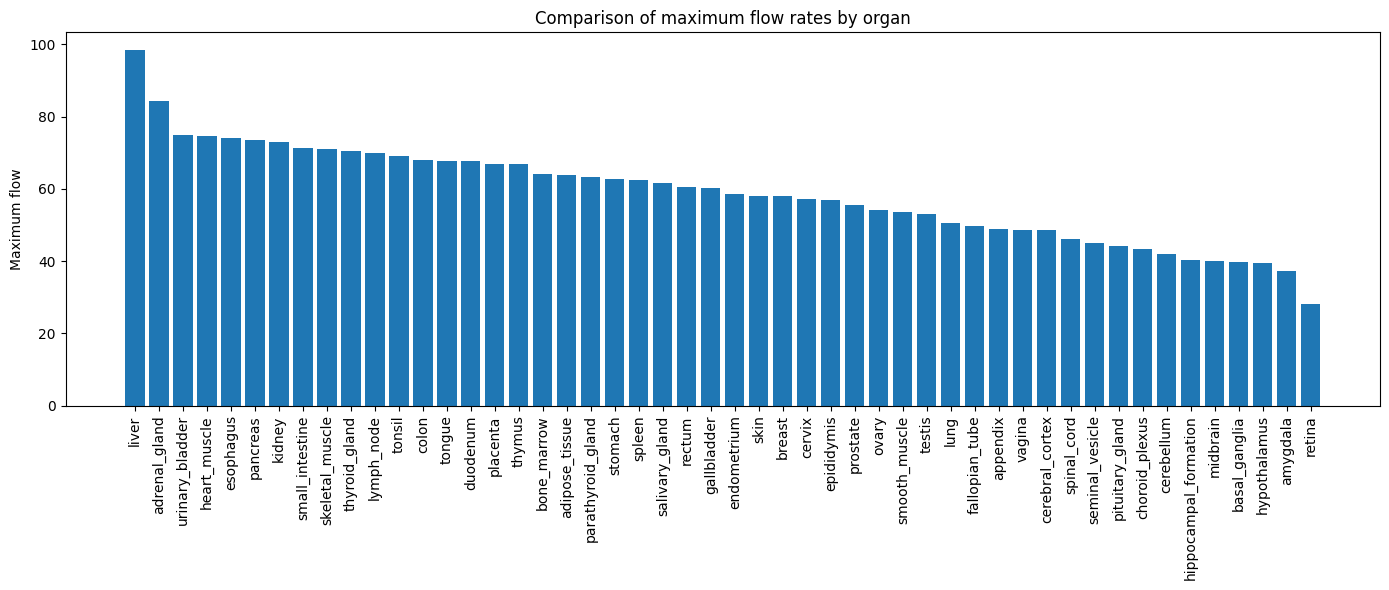

In [ ]:
import networkx as nx
import pandas as pd
import os
import matplotlib.pyplot as plt

# 糖鎖パスウェイ構造読み込み（共通）
G_base = nx.read_graphml("glycan_synthesis_only.graphml")
print(f"✅ G_base loaded: {len(G_base.nodes)} nodes, {len(G_base.edges)} edges")

# 各臓器のCSVファイルを探す（事前に作ったやつ）
files = [f for f in os.listdir() if f.startswith("reaction_ec_gene_with_tpm_") and f.endswith(".csv")]

results = []

# 各臓器ごとに最大フローを計算
for file in sorted(files):
    tissue = file.replace("reaction_ec_gene_with_tpm_", "").replace(".csv", "")
    df_expr = pd.read_csv(file)
    df_expr = df_expr[df_expr["nTPM"].notna() & (df_expr["nTPM"] > 1)]
    valid_reactions = set(df_expr["Reaction_ID"].unique())
    cap_dict = df_expr.set_index("Reaction_ID")["nTPM"].to_dict()

    # capacity付きグラフ構築
    G = nx.DiGraph()
    for u, v, data in G_base.edges(data=True):
        rid = data.get("reaction_name", "").strip()
        if rid in cap_dict:
            G.add_edge(u, v, capacity=cap_dict[rid])

    # スーパーソース／シンク
    source = "SuperSource"
    sink = "SuperSink"
    G.add_node(source)
    G.add_node(sink)

    for node in G.nodes:
        if node not in [source, sink] and G.in_degree(node) == 0 and G.out_degree(node) > 0:
            G.add_edge(source, node, capacity=float("inf"))
        if node not in [source, sink] and G.out_degree(node) == 0 and G.in_degree(node) > 0:
            G.add_edge(node, sink, capacity=float("inf"))

    # 最大フロー計算
    try:
        flow_val, _ = nx.maximum_flow(G, source, sink, capacity="capacity")
        print(f"✅ {tissue}: MaxFlow = {flow_val}")
    except Exception as e:
        flow_val = 0
        print(f"❌ {tissue}: エラー → {e}")

    results.append({"Tissue": tissue, "MaxFlow": flow_val})

# 結果を保存
df_result = pd.DataFrame(results).sort_values("MaxFlow", ascending=False)
df_result.to_csv("tissue_maxflow_capacityTPM_result.csv", index=False)
print("📦 結果を tissue_maxflow_capacityTPM_result.csv に保存しました")

# 可視化
plt.figure(figsize=(14, 6))
plt.bar(df_result["Tissue"], df_result["MaxFlow"])
plt.xticks(rotation=90)
plt.ylabel("Maximum flow")
plt.title("Comparison of maximum flow rates by organ")
plt.tight_layout()
plt.savefig("maxflow_comparison_by_tissue.png", dpi=300)
plt.show()


In [ ]:
import pandas as pd

# 最大フロー結果読み込み
df_flow = pd.read_csv("tissue_maxflow_capacityTPM_result.csv")

# トップ3 & ボトム3 臓器
top3 = df_flow.sort_values("MaxFlow", ascending=False).head(3)
bottom3 = df_flow.sort_values("MaxFlow", ascending=True).head(3)

print("🔺 Top 3 tissues:")
print(top3)
print("\n🔻 Bottom 3 tissues:")
print(bottom3)


🔺 Top 3 tissues:
            Tissue  MaxFlow
0            liver     98.4
1    adrenal_gland     84.2
2  urinary_bladder     74.8

🔻 Bottom 3 tissues:
          Tissue  MaxFlow
49        retina     28.0
48      amygdala     37.3
47  hypothalamus     39.4


In [ ]:
import pandas as pd

# 最大フロー結果読み込み
df_flow = pd.read_csv("tissue_maxflow_capacityTPM_result.csv")

# EC付きのマップデータ
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")
df_map_ec = df_map[["Reaction_ID", "Gene_Symbol", "EC"]].dropna(subset=["EC"])

# === Top臓器処理 ===
top_tissue = df_flow.sort_values("MaxFlow", ascending=False)["Tissue"].iloc[0]
print(f"🧠 最大フロー1位の臓器：{top_tissue}")

file_top = f"reaction_ec_gene_with_tpm_{top_tissue}.csv"
df_top = pd.read_csv(file_top)
df_top = df_top[df_top["nTPM"].notna() & (df_top["nTPM"] > 1)]
df_top = df_top.merge(df_map_ec, on=["Reaction_ID", "Gene_Symbol"], how="left")

top_genes = df_top.sort_values("nTPM", ascending=False).drop_duplicates("Gene_Symbol").head(10)
print("🔝 高TPM酵素（Top臓器）:")
print(top_genes[["Reaction_ID", "Gene_Symbol", "nTPM", "EC_y"]].rename(columns={"EC_y": "EC"}))

# === Bottom臓器処理 ===
bottom_tissue = df_flow.sort_values("MaxFlow", ascending=True)["Tissue"].iloc[0]
print(f"💤 最小フローの臓器：{bottom_tissue}")

file_bot = f"reaction_ec_gene_with_tpm_{bottom_tissue}.csv"
df_bot = pd.read_csv(file_bot)
df_bot = df_bot[df_bot["nTPM"].notna() & (df_bot["nTPM"] > 1)]
df_bot = df_bot.merge(df_map_ec, on=["Reaction_ID", "Gene_Symbol"], how="left")

bottom_genes = df_bot.sort_values("nTPM", ascending=False).drop_duplicates("Gene_Symbol").head(10)
print("🔻 高TPM酵素（Bottom臓器）:")
print(bottom_genes[["Reaction_ID", "Gene_Symbol", "nTPM", "EC_y"]].rename(columns={"EC_y": "EC"}))


🧠 最大フロー1位の臓器：liver
🔝 高TPM酵素（Top臓器）:
   Reaction_ID Gene_Symbol   nTPM         EC
24   rn:R05990     ST6GAL1  480.8    2.4.3.1
18   rn:R05987      MGAT4B  270.4  2.4.1.145
13   rn:R05981       GANAB  166.5  3.2.1.207
40   rn:R12479      MAN1A1  150.0  3.2.1.113
14   rn:R05983       MGAT1  143.3  2.4.1.101
21   rn:R05989     B4GALT1   87.2   2.4.1.38
9    rn:R05976       STT3B   72.6  2.4.99.18
10   rn:R05976       STT3A   66.9  2.4.99.18
2    rn:R01009        DPM1   60.3   2.4.1.83
1    rn:R01005        ALG5   60.0  2.4.1.117
💤 最小フローの臓器：retina
🔻 高TPM酵素（Bottom臓器）:
   Reaction_ID Gene_Symbol  nTPM         EC
13   rn:R05981       GANAB  77.0  3.2.1.207
15   rn:R05984      MAN2A2  72.6  3.2.1.114
10   rn:R05976       STT3A  38.8  2.4.99.18
9    rn:R05976       STT3B  37.4  2.4.99.18
14   rn:R05983       MGAT1  28.3  2.4.1.101
22   rn:R05989     B4GALT1  25.4   2.4.1.38
2    rn:R01009        DPM1  21.1   2.4.1.83
40   rn:R12479      MAN1A2  17.7  3.2.1.113
30   rn:R06238        ALG2  14.5  2

直列モデル
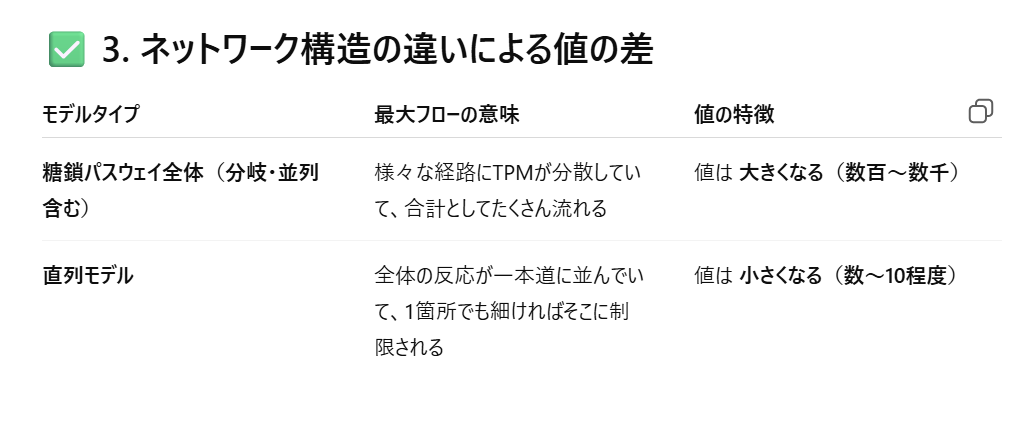

✅ adipose tissue  MaxFlow = 0.30
✅ adrenal gland   MaxFlow = 1.00
✅ amygdala        MaxFlow = 0.90
✅ appendix        MaxFlow = 0.00
✅ basal ganglia   MaxFlow = 1.00
✅ bone marrow     MaxFlow = 0.00
✅ breast          MaxFlow = 0.00
✅ cerebellum      MaxFlow = 0.70
✅ cerebral cortex MaxFlow = 1.90
✅ cervix          MaxFlow = 0.20
✅ choroid plexus  MaxFlow = 0.00
✅ colon           MaxFlow = 0.40
✅ duodenum        MaxFlow = 0.00
✅ endometrium     MaxFlow = 0.00
✅ epididymis      MaxFlow = 0.80
✅ esophagus       MaxFlow = 0.00
✅ fallopian tube  MaxFlow = 0.10
✅ gallbladder     MaxFlow = 0.10
✅ heart muscle    MaxFlow = 1.60
✅ hippocampal formation MaxFlow = 0.80
✅ hypothalamus    MaxFlow = 0.70
✅ kidney          MaxFlow = 0.10
✅ liver           MaxFlow = 0.10
✅ lung            MaxFlow = 0.10
✅ lymph node      MaxFlow = 0.00
✅ midbrain        MaxFlow = 0.80
✅ ovary           MaxFlow = 0.00
✅ pancreas        MaxFlow = 0.10
✅ parathyroid gland MaxFlow = 0.00
✅ pituitary gland MaxFlow = 1.10
✅ 

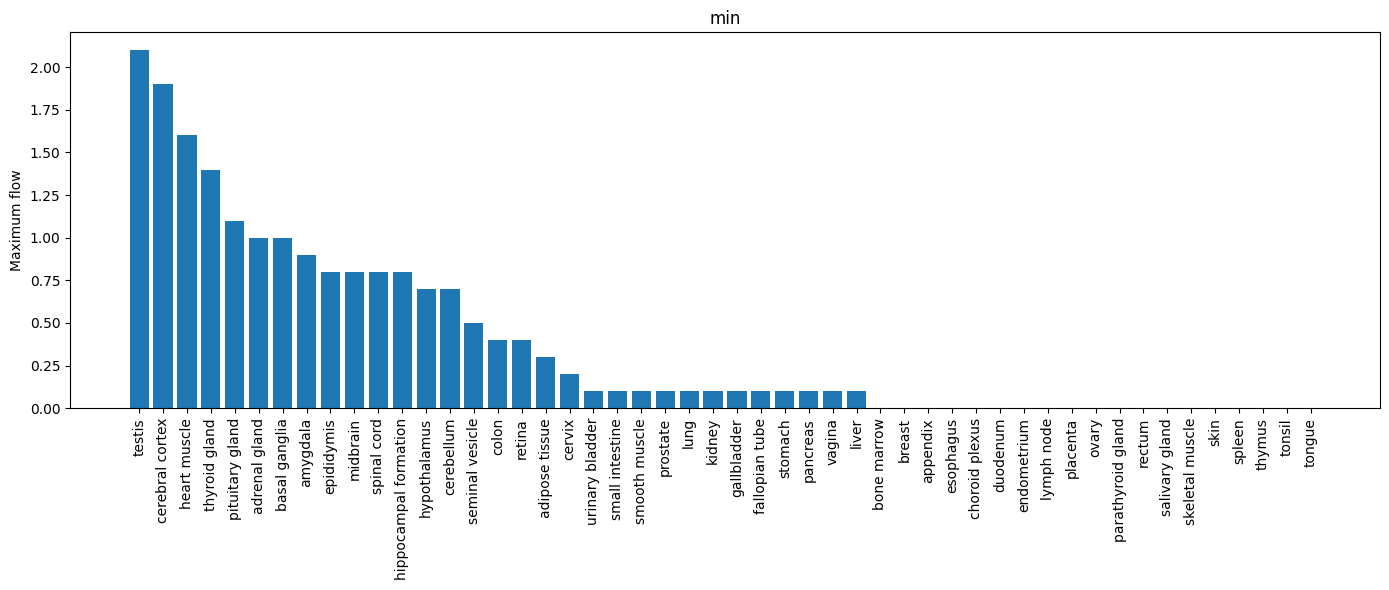

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# === データ読み込み ===
df_map  = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")   # Reaction ↔ EC ↔ Gene
df_expr = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")  # 各組織の nTPM

# === 反応リストを取得して直列モデルのベースを作成 ===
reactions = df_map["Reaction_ID"].unique().tolist()
G_base = nx.DiGraph()
for i in range(len(reactions) - 1):
    u, v = reactions[i], reactions[i+1]
    G_base.add_edge(u, v)  # 容量は後で設定

# === 結果格納用 ===
results = []

# === 各組織ごとに最大フローを計算 ===
for tissue in sorted(df_expr["Tissue"].unique()):
    # （1）当該組織の発現量だけ抽出し、辞書にする
    df_t = df_expr[df_expr["Tissue"] == tissue][["Gene name", "nTPM"]]
    expr_dict = df_t.set_index("Gene name")["nTPM"].to_dict()

    # （2）ベースグラフをコピーし、各エッジに capacity を設定
    G = G_base.copy()
    for u, v in G.edges():
        # u（Reaction_ID）に紐づく遺伝子を抽出
        genes = df_map[df_map["Reaction_ID"] == u]["Gene_Symbol"].dropna().unique()
        # その中の発現量リスト
        caps = [ expr_dict.get(g, 0.0) for g in genes ]
        # 「最大発現量」を capacity に（お好みで sum()/mean() に変更可）
        G[u][v]["capacity"] = max(caps) if caps else 0.0

    # （3）スーパーソース／シンクを追加
    source, sink = "SuperSource", "SuperSink"
    G.add_node(source); G.add_node(sink)
    # 始点（in_degree==0）→ source, 終点（out_degree==0）→ sink
    for n in reactions:
        if G.in_degree(n) == 0:
            G.add_edge(source, n, capacity=float("inf"))
        if G.out_degree(n) == 0:
            G.add_edge(n, sink, capacity=float("inf"))

    # （4）最大フロー計算
    flow_value, _ = nx.maximum_flow(G, source, sink, capacity="capacity")
    results.append((tissue, flow_value))
    print(f"✅ {tissue:<15} MaxFlow = {flow_value:.2f}")

# === DataFrame化してソート ===
df_res = pd.DataFrame(results, columns=["Tissue","MaxFlow"])
df_res = df_res.sort_values("MaxFlow", ascending=False)

# === 結果を保存 ===
df_res.to_csv("tissue_maxflow_result.csv", index=False)
print("→ tissue_maxflow_result.csv に保存しました")

# === 棒グラフで可視化 ===
plt.figure(figsize=(14,6))
plt.bar(df_res["Tissue"], df_res["MaxFlow"])
plt.xticks(rotation=90)
plt.ylabel("Maximum flow")
plt.title("min")
plt.tight_layout()
plt.show()


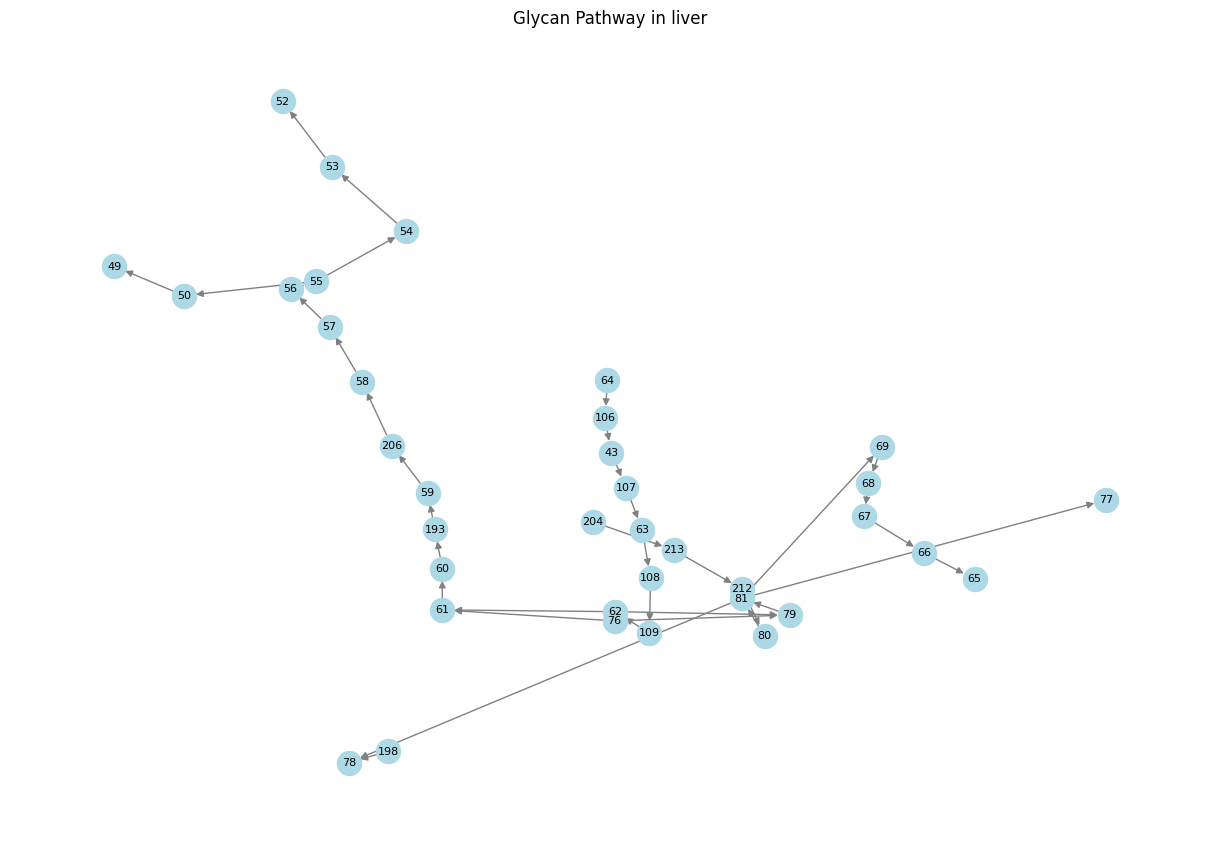

In [ ]:
import pandas as pd

df_rna = pd.read_csv("rna_tissue_consensus[1].tsv", sep="\t")

# Tissueごとに発現している遺伝子の一覧を取得（例: nTPM > 1でフィルタ）
tissue_gene_dict = {
    tissue: group[group["nTPM"] > 1]["Gene name"].unique().tolist()
    for tissue, group in df_rna.groupby("Tissue")
}
import networkx as nx

# Reaction-EC-Gene情報（マッピングファイル）
df_map = pd.read_csv("reaction_ec_gene_mapping_expanded.csv")

# 糖鎖パスウェイの反応ネットワーク（例：GraphMLで作ったやつ）
G_reaction = nx.read_graphml("glycan_synthesis_only.graphml")

tissue_networks = {}

for tissue, genes in tissue_gene_dict.items():
    G_tissue = nx.DiGraph()

    # 遺伝子が関与している反応だけを抽出
    reactions = df_map[df_map["Gene_Symbol"].isin(genes)]["Reaction_ID"].unique()

    for u, v, data in G_reaction.edges(data=True):
        if data.get("reaction_name") in reactions:
            G_tissue.add_edge(u, v, **data)

    tissue_networks[tissue] = G_tissue

import matplotlib.pyplot as plt

tissue = "liver"  # 可視化したい部位名
G = tissue_networks[tissue]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=300, font_size=8)
plt.title(f"Glycan Pathway in {tissue}")
plt.show()


##臓器の差をとってみる

In [ ]:
import pandas as pd

# 各組織ファイル読み込み
df_liver = pd.read_csv("reaction_ec_gene_with_tpm_liver.csv")
df_kidney = pd.read_csv("reaction_ec_gene_with_tpm_kidney.csv")

# Reaction_ID ごとに nTPM を平均・合計する
df_liver_grp = df_liver.groupby("Reaction_ID").agg({"nTPM": ["mean", "sum"]}).reset_index()
df_liver_grp.columns = ["Reaction_ID", "TPM_liver_mean", "TPM_liver_sum"]

df_kidney_grp = df_kidney.groupby("Reaction_ID").agg({"nTPM": ["mean", "sum"]}).reset_index()
df_kidney_grp.columns = ["Reaction_ID", "TPM_kidney_mean", "TPM_kidney_sum"]

df_diff = df_liver_grp.merge(
    df_kidney_grp,
    on="Reaction_ID",
    how="outer"
).fillna(0)  # どちらかにない場合は0で埋める

df_diff["TPM_diff_mean"] = df_diff["TPM_liver_mean"] - df_diff["TPM_kidney_mean"]
df_diff["TPM_diff_sum"] = df_diff["TPM_liver_sum"] - df_diff["TPM_kidney_sum"]

print(df_diff.head())

df_diff.to_csv("reaction_tpm_diff_liver_vs_kidney.csv", index=False)
print("✅ 差分テーブル saved: reaction_tpm_diff_liver_vs_kidney.csv")

  Reaction_ID  TPM_liver_mean  TPM_liver_sum  TPM_kidney_mean  TPM_kidney_sum  \
0   rn:R01004            21.8           21.8              5.8             5.8   
1   rn:R01005            60.0           60.0             39.7            39.7   
2   rn:R01009            60.3           60.3             44.6            44.6   
3   rn:R01018            10.2           10.2              8.8             8.8   
4   rn:R05969            20.1           20.1             12.1            12.1   

   TPM_diff_mean  TPM_diff_sum  
0           16.0          16.0  
1           20.3          20.3  
2           15.7          15.7  
3            1.4           1.4  
4            8.0           8.0  
✅ 差分テーブル saved: reaction_tpm_diff_liver_vs_kidney.csv


In [ ]:
import networkx as nx
import pandas as pd

# GraphML 読み込み
G = nx.read_graphml("glycan_synthesis_only.graphml")

# 差分テーブル
df_diff = pd.read_csv("reaction_tpm_diff_liver_vs_kidney.csv")

# Edgeの reaction_name に対応して差分を突合
for u, v, data in G.edges(data=True):
    if data.get("edge_type") == "reaction":
        reaction_id = data.get("reaction_name")  # 例: rn:R05983
        row = df_diff[df_diff["Reaction_ID"] == reaction_id]
        if not row.empty:
            data["TPM_liver_mean"] = row["TPM_liver_mean"].values[0]
            data["TPM_kidney_mean"] = row["TPM_kidney_mean"].values[0]
            data["TPM_diff_mean"] = row["TPM_diff_mean"].values[0]

# 差分を載せた新しい GraphML 保存
nx.write_graphml(G, "glycan_pathway_with_tpm_diff.graphml")
print("✅ 差分を載せた GraphML 保存完了！")

✅ 差分を載せた GraphML 保存完了！


## TPM valueを重みにしたグラフを作成
臓器によって値が異なる＝キャパシティが異なる

In [ ]:
import networkx as nx
import pandas as pd

# 元の KEGG グラフ
G = nx.read_graphml("glycan_synthesis_only.graphml")

# 差分テーブル（Reaction 単位）
df_diff = pd.read_csv("reaction_tpm_diff_liver_vs_kidney.csv")

missing = []

# エッジ属性を Reaction にだけ付与
for u, v, data in G.edges(data=True):
    if data.get("edge_type") == "reaction":
        # まず reaction_name を試す
        reaction_id = data.get("reaction_name")

        # reaction_name がない場合は reaction_id を fallback にする
        if reaction_id is None or reaction_id == "":
            reaction_id = data.get("reaction_id")

        if reaction_id is None or reaction_id == "":
            missing.append(f"{u}->{v} Reaction edge に ID がない")
            continue

        row = df_diff[df_diff["Reaction_ID"] == reaction_id]

        if not row.empty:
            data["TPM_liver_mean"] = float(row["TPM_liver_mean"].values[0])
            data["TPM_liver_sum"]  = float(row["TPM_liver_sum"].values[0])
            data["TPM_kidney_mean"] = float(row["TPM_kidney_mean"].values[0])
            data["TPM_kidney_sum"]  = float(row["TPM_kidney_sum"].values[0])
            data["TPM_diff_mean"]  = float(row["TPM_diff_mean"].values[0])
            data["TPM_diff_sum"]   = float(row["TPM_diff_sum"].values[0])
            data["weight_liver"]   = float(row["TPM_liver_mean"].values[0])
            data["weight_kidney"]  = float(row["TPM_kidney_mean"].values[0])
        else:
            missing.append(f"{u}->{v} Reaction_ID not matched: {reaction_id}")

print("✅ Reaction edge に TPM_mean, TPM_sum を両方追加しました")

if missing:
    print("\n=== ❌ 不一致・ID無し ===")
    for m in missing:
        print(m)
else:
    print("\n✅ 全部一致しました")

# 保存
nx.write_graphml(G, "glycan_pathway_with_tpm_mean_sum.graphml")
print("✅ GraphML 保存: glycan_pathway_with_tpm_mean_sum.graphml")

FileNotFoundError: [Errno 2] No such file or directory: 'reaction_tpm_diff_liver_vs_kidney.csv'

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. 読み込み
G = nx.read_graphml("glycan_pathway_with_tpm_mean_sum.graphml")

# 2. 可視化対象（reactionエッジのみ）
edges = [(u, v) for u, v, d in G.edges(data=True) if d.get("edge_type") == "reaction"]

# 3. 差分（liver vs kidney）の取り出し
colors = []
for u, v in edges:
    diff = G[u][v].get("TPM_diff_mean", 0)
    colors.append(diff)

# 4. レイアウト（ランダム or spring）
pos = nx.spring_layout(G, seed=42)

# 5. 描画
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightgray')
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors, edge_cmap=plt.cm.seismic, width=2)
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), label="TPM_diff_mean (liver - kidney)")
plt.title("Glycan Pathway Reaction TPM Difference: Liver vs Kidney")
plt.axis("off")
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'glycan_pathway_with_tpm_mean_sum.graphml'

##お試しで最大フロー問題を解く
念の為の動作確認です．全然正確じゃないのでご注意を．

In [ ]:
import networkx as nx
import pandas as pd
from networkx.algorithms.flow import maximum_flow

# === GraphML 読み込み ===
G = nx.read_graphml("glycan_pathway_with_tpm_mean_sum.graphml")

# === Reaction edge に capacity を liver 版で設定 ===
for u, v, data in G.edges(data=True):
    if data.get("edge_type") == "reaction":
        data["capacity"] = float(data.get("TPM_liver_sum", 0))

print("✅ Reaction edge に capacity 設定完了")

# === Source / Sink を抽出 ===
sources = [n for n in G.nodes() if G.in_degree(n) == 0]
sinks   = [n for n in G.nodes() if G.out_degree(n) == 0]

print("Sources:", sources)
print("Sinks:", sinks)

# === flow_dict から順序つきパスを復元する関数（visitedつき） ===
def get_flow_paths(flow_dict, source, sink):
    H = nx.DiGraph()
    for u, v_dict in flow_dict.items():
        for v, flow in v_dict.items():
            if flow > 0:
                H.add_edge(u, v, flow=flow)

    all_paths = []

    def dfs(u, path, bottleneck, visited):
        if u == sink:
            all_paths.append( (path[:], bottleneck) )
            return
        for v in H.successors(u):
            if v not in visited:
                edge_flow = H[u][v]['flow']
                if edge_flow > 0:
                    new_bottleneck = min(bottleneck, edge_flow)
                    visited.add(v)
                    dfs(v, path + [v], new_bottleneck, visited)
                    visited.remove(v)

    visited = set([source])
    dfs(source, [source], float('inf'), visited)

    return all_paths

# === 全ペアで最大フローを計算 & パス列挙 ===
results = []

for s in sources:
    for t in sinks:
        if nx.has_path(G, s, t):
            flow_value, flow_dict = maximum_flow(G, s, t, capacity='capacity')
            paths = get_flow_paths(flow_dict, s, t)
            for path, path_flow in paths:
                results.append({
                    "source": s,
                    "sink": t,
                    "path": " → ".join(path),
                    "path_flow": path_flow
                })
            print(f"✅ {s} → {t} | Total flow: {flow_value:.2f} | Paths found: {len(paths)}")
        else:
            print(f"❌ {s} → {t} : No path")

# === DataFrame 化 ===
df_paths = pd.DataFrame(results).sort_values(by="path_flow", ascending=False)
print("\n=== All Flow Paths ===")
print(df_paths.head())

# === Sink 糖鎖ごとの最終生成量を集計 ===
df_sink_sum = (
    df_paths.groupby("sink")["path_flow"]
    .sum()
    .reset_index()
    .sort_values(by="path_flow", ascending=False)
)

# sink の糖鎖名も付ける
sink_labels = []
for sink_id in df_sink_sum["sink"]:
    node_data = G.nodes[sink_id]
    label = node_data.get("label", sink_id)
    sink_labels.append(label)

df_sink_sum["sink_label"] = sink_labels

print("\n=== Sink-wise Total Generated Amounts ===")
print(df_sink_sum)

# === 保存 ===
df_paths.to_csv("glycan_pathway_flow_paths.csv", index=False)
df_sink_sum.to_csv("glycan_pathway_sink_totals.csv", index=False)
print("\n✅ Flow paths saved: glycan_pathway_flow_paths.csv")
print("✅ Sink total amounts saved: glycan_pathway_sink_totals.csv")

✅ Reaction edge に capacity 設定完了
Sources: ['76', '204', '198']
Sinks: ['48', '51', '52', '77', '78']
✅ 76 → 48 | Total flow: 0.10 | Paths found: 1
✅ 76 → 51 | Total flow: 0.20 | Paths found: 1
✅ 76 → 52 | Total flow: 3.30 | Paths found: 1
✅ 76 → 77 | Total flow: 21.80 | Paths found: 1
✅ 76 → 78 | Total flow: 21.80 | Paths found: 1


NetworkXError: The node 204 is not in the digraph.